SOURCE: https://www.kaggle.com/competitions/ai-drug-discovery/overview
<br>Objective: The objective of the task is to develop a binary classification model to estimate the cytopathic effect (CPE) of severe acute respiratory syndrome coronavirus 2 (SARS-CoV-2) on compounds provided in a dataset. The dataset consists of molecules represented in Simplified Molecular Input Line Entry System (SMILES) format, along with corresponding labels indicating their activity as either active (1) or inactive (0) against the viral infectivity.

The goal is to build a model that can accurately classify compounds as active or inactive based on their molecular features. This model can be valuable for the scientific community in prioritizing compounds for in vitro screening and expediting the discovery of potential drug candidates for the treatment of coronavirus disease 2019 (COVID-19).

<br><br>Importing libraries

In [3]:
!pip install rdkit

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.7/29.7 MB 50.5 MB/s eta 0:00:00


In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem.rdMolDescriptors import CalcMolFormula
from rdkit.Chem import Descriptors
from tqdm import tqdm
from sklearn.metrics import accuracy_score
import xgboost as xgb

In [4]:
from custom_pipeline import *

Loading training data

In [9]:
train=pd.read_csv('data/training-set.csv')
train.head()

,MOL.ID,DC.ID,SMILES_stand,InChI,SMILES,DC.NAME,NCATS.SYNONYMS,NCGC.ID,WARNING,3CL.SIGNIFICANCE,...,AlphaLISA.SIGNIFICANCE,CPE.ACTIVITY,CPE.SIGNIFICANCE,TruHit.ACTIVITY,TruHit.SIGNIFICANCE,cytotox.ACTIVITY,cytotox.SIGNIFICANCE,logPow {predicted by ochem.eu/model/535 in Log unit},Aqueous Solubility {predicted by ochem.eu/model/536 in log(mol/L)},Label
0,MOL26,60.0,CC(=O)SCC(Cc1ccccc1)C(=O)NCC(=O)OCc1ccccc1,InChI=1S/C21H23NO4S/c1-16(23)27-15-19(12-17-8-...,CC(=O)SCC(Cc1ccccc1)C(=O)NCC(=O)OCc1ccccc1,racecadotril,NaN,"NCGC00179511-08, NCGC00179511-04, NCGC00179511-03",NaN,INACTIVE,...,NaN,LOW,INACTIVE,NaN,NaN,LOW,INACTIVE,2.72,-5.34,0
1,MOL9127,NaN,Cc1c(OCc2cccc(-c3ccc(C(=O)O)cc3)c2)cc2c(c1C)C(...,InChI=1S/C30H30O4/c1-18-19(2)28-25(15-26(29(28...,Cc1c(OCc2cccc(-c3ccc(C(=O)O)cc3)c2)cc2c(c1C)C(...,NaN,NaN,NCGC00370788-02,NaN,INACTIVE,...,NaN,MODERATE,LOW,NaN,NaN,LOW,INACTIVE,6.12,-7.14,1
2,MOL4184,NaN,COc1ccccc1Nc1nc(-c2sc(NC(C)=O)nc2C)cs1,InChI=1S/C16H16N4O2S2/c1-9-14(24-16(17-9)18-10...,COc1ccccc1Nc1nc(-c2sc(NC(C)=O)nc2C)cs1,NaN,NaN,NCGC00282602-03,NaN,NaN,...,NaN,MODERATE,MODERATE,NaN,NaN,LOW,INACTIVE,3.79,-4.30,1
3,MOL6792,NaN,O=C1O[C@]2(CC[C@@H](C(=O)Nc3ccn(-c4ccccc4F)n3)...,InChI=1S/C22H19FN4O3/c23-17-3-1-2-4-18(17)27-1...,O=C1O[C@]2(CC[C@@H](C(=O)Nc3ccn(-c4ccccc4F)n3)...,NaN,NaN,NCGC00509989-01,NaN,INACTIVE,...,NaN,LOW,INACTIVE,NaN,NaN,LOW,INACTIVE,2.96,-4.49,0
4,MOL2176,4171.0,C=C1C[C@@H]2CC[C@@]34C[C@H]5O[C@H]6[C@@H](O3)[...,InChI=1S/C40H59NO11/c1-19-11-24-5-7-28-20(2)12...,C=C1C[C@@H]2CC[C@@]34C[C@H]5O[C@H]6[C@@H](O3)[...,eribulin,Eribulin mesylate,NCGC00510497-01,NaN,INACTIVE,...,INACTIVE,LOW,INACTIVE,LOW,INACTIVE,MODERATE,HIGH,1.26,-3.96,0


Checking nan values (unfortunatelly the dataset is full of them)

In [10]:
nan_percentage=(train.isna().sum()/len(train)*100).sort_values(ascending=0)
nan_percentage

WARNING                                                               99.856734
DC.ID                                                                 74.068768
DC.NAME                                                               74.068768
MERS-PPE_cs.SIGNIFICANCE                                              71.919771
CoV1-PPE.SIGNIFICANCE                                                 71.919771
MERS-PPE_cs.ACTIVITY                                                  71.919771
MERS-PPE.ACTIVITY                                                     71.919771
MERS-PPE.SIGNIFICANCE                                                 71.919771
CoV1-PPE_cs.ACTIVITY                                                  71.919771
CoV1-PPE.ACTIVITY                                                     71.919771
CoV1-PPE_cs.SIGNIFICANCE                                              71.919771
NCATS.SYNONYMS                                                        66.332378
TruHit.ACTIVITY                         

Creating a list of columns with nan values percentage > 50

In [11]:
columns_with_high_nan = nan_percentage[nan_percentage >= 50].index.tolist()
columns_with_high_nan

['WARNING',
 'DC.ID',
 'DC.NAME',
 'MERS-PPE_cs.SIGNIFICANCE',
 'CoV1-PPE.SIGNIFICANCE',
 'MERS-PPE_cs.ACTIVITY',
 'MERS-PPE.ACTIVITY',
 'MERS-PPE.SIGNIFICANCE',
 'CoV1-PPE_cs.ACTIVITY',
 'CoV1-PPE.ACTIVITY',
 'CoV1-PPE_cs.SIGNIFICANCE',
 'NCATS.SYNONYMS',
 'TruHit.ACTIVITY',
 'ACE2.ACTIVITY',
 'ACE2.SIGNIFICANCE',
 'AlphaLISA.ACTIVITY',
 'AlphaLISA.SIGNIFICANCE',
 'TruHit.SIGNIFICANCE',
 'hCYTOX.SIGNIFICANCE',
 'hCYTOX.ACTIVITY']

Checking types of variables of columns with high nan percentage - turns out they are mostly categorical

In [12]:
for column in columns_with_high_nan:
    print('____________')
    print(f'column: {column}')
    print(train[column].unique()[:10])

____________
column: WARNING
[nan 'Has non-drug elements']
____________
column: DC.ID
[  60.   nan 4171. 2875. 3825. 1873.  810. 1942. 1971.  681.]
____________
column: DC.NAME
['racecadotril' nan 'eribulin' 'zotepine' 'rescimetol' 'naftopidil'
 'deserpidine' 'nisoldipine' 'nortriptyline' 'clioquinol']
____________
column: MERS-PPE_cs.SIGNIFICANCE
[nan 'INACTIVE' 'LOW' 'HIGH' 'MODERATE' 'INCONCLUSIVE']
____________
column: CoV1-PPE.SIGNIFICANCE
[nan 'INACTIVE' 'MODERATE' 'LOW' 'HIGH' 'INCONCLUSIVE']
____________
column: MERS-PPE_cs.ACTIVITY
[nan 'LOW' 'MODERATE' 'HIGH']
____________
column: MERS-PPE.ACTIVITY
[nan 'LOW' 'MODERATE' 'HIGH']
____________
column: MERS-PPE.SIGNIFICANCE
[nan 'INACTIVE' 'LOW' 'MODERATE' 'INCONCLUSIVE' 'HIGH']
____________
column: CoV1-PPE_cs.ACTIVITY
[nan 'LOW' 'MODERATE' 'HIGH']
____________
column: CoV1-PPE.ACTIVITY
[nan 'LOW' 'HIGH' 'MODERATE']
____________
column: CoV1-PPE_cs.SIGNIFICANCE
[nan 'INACTIVE' 'HIGH' 'LOW' 'MODERATE']
____________
column: NCATS.

Dealing with columns with high nan percentage:
<br>'WARNING', 'DC.ID', 'DC.NAME', 'NCATS.SYNONYMS', 'NCGC.ID' - those columns will not provide any straightforward useful information for machine learning model, therefore they can be dropped (some of them could be used to scrape some additional data, but I will not do that)
<br>In the remaining columns I am replacing nan values with 'UNKNOWN' which will be later encoded with rest of categorical values

In [13]:
train=train.drop(['WARNING', 'DC.ID', 'DC.NAME', 'NCATS.SYNONYMS', 'NCGC.ID'], axis=1)
nan_percentage=(train.isna().sum()/len(train)*100).sort_values(ascending=0) #updating nan_percentage
act_and_sign=nan_percentage[nan_percentage >= 50].index.tolist() #remaining columns
train[act_and_sign] = train[act_and_sign].fillna('UNKNOWN')

Now it is possible to use .dropna() without losing most of the data from dataframe - in fact 663 out of 697 rows are still remaining

In [14]:
train=train.dropna()
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 663 entries, 0 to 697
Data columns (total 29 columns):
 #   Column                                                              Non-Null Count  Dtype  
---  ------                                                              --------------  -----  
 0   MOL.ID                                                              663 non-null    object 
 1   SMILES_stand                                                        663 non-null    object 
 2   InChI                                                               663 non-null    object 
 3   SMILES                                                              663 non-null    object 
 4   3CL.SIGNIFICANCE                                                    663 non-null    object 
 5   3CL.ACTIVITY                                                        663 non-null    object 
 6   CoV1-PPE.SIGNIFICANCE                                               663 non-null    object 
 7   CoV1-PPE.ACTIVITY

Creating a list of categorical columns to encode

In [15]:
sign_and_act_cols=[column for column in train.columns if "SIGNIFICANCE" in column or "ACTIVITY" in column]

Checking what unique values they contain

In [16]:
unique_values = train[sign_and_act_cols].values.ravel()
unique_values = pd.unique(unique_values)
unique_values

array(['INACTIVE', 'LOW', 'UNKNOWN', 'HIGH', 'MODERATE', 'INCONCLUSIVE'],
      dtype=object)

Here I have made 2 important assumptions:
<br>1. 'INCONCLUSIVE' has more or less same meaning as 'UNKNOWN' and therefore those 2 values can be merged into 1
<br>2. Rest of values can be ordered from lowest to highest in a following way: inactive, low, moderate, high and therefore ordinal encoding can be performed on them (this way I can avoid making the model too complex).
<br>
<br>The values are encoded following way:
<br>'INACTIVE': -2,
<br>'LOW': -1,
<br>'UNKNOWN': 0,
<br>'MODERATE': 1,
<br>'HIGH': 2

In [17]:
train[sign_and_act_cols] = train[sign_and_act_cols].replace('INCONCLUSIVE', 'UNKNOWN')
mapping = {
    'INACTIVE': -2,
    'LOW': -1,
    'UNKNOWN': 0,
    'MODERATE': 1,
    'HIGH': 2
}
train[sign_and_act_cols] = train[sign_and_act_cols].applymap(mapping.get)

Checking how correlated the features are with 'Label' column

In [18]:
np.abs(train.corr()['Label']).sort_values(ascending=0)

<ipython-input-18-dc2de6cf3cd6>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  np.abs(train.corr()['Label']).sort_values(ascending=0)


Label                                                                 1.000000
CPE.ACTIVITY                                                          0.960577
CPE.SIGNIFICANCE                                                      0.701137
MERS-PPE.ACTIVITY                                                     0.306884
logPow {predicted by ochem.eu/model/535 in Log unit}                  0.257988
TruHit.SIGNIFICANCE                                                   0.244148
CoV1-PPE.ACTIVITY                                                     0.235555
TruHit.ACTIVITY                                                       0.221239
Aqueous Solubility {predicted by ochem.eu/model/536 in log(mol/L)}    0.198976
cytotox.ACTIVITY                                                      0.188303
MERS-PPE.SIGNIFICANCE                                                 0.169664
AlphaLISA.ACTIVITY                                                    0.164927
AlphaLISA.SIGNIFICANCE                              

It turns out you only need CPE.ACTIVITY and CPE.SIGNIFICANCE (or even just one of those features since they are most likely highly correlated anyway) for this classification problem. However since the data consisted of massive number of nan values I am going to keep more features in case those CPE values were not available (even though these particural columns did not contain nan values in training set)

<Axes: xlabel='CPE.ACTIVITY', ylabel='Count'>

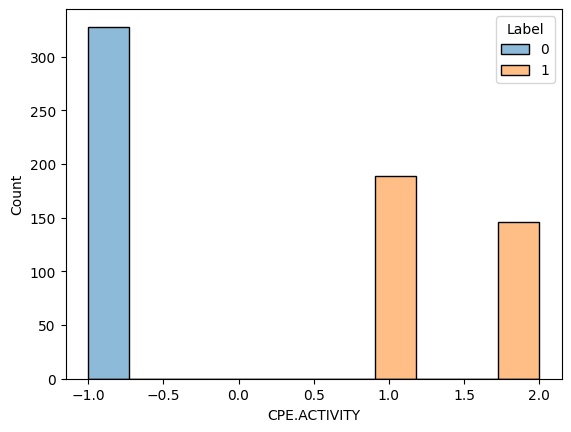

In [19]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.histplot(data=train, x='CPE.ACTIVITY', hue='Label')

<Axes: xlabel='CPE.SIGNIFICANCE', ylabel='Count'>

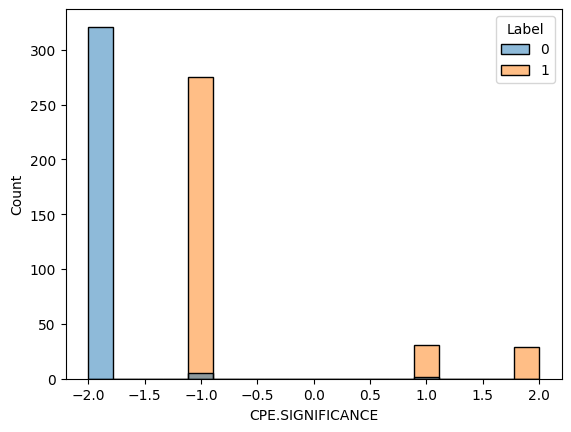

In [20]:
sns.histplot(data=train, x='CPE.SIGNIFICANCE', hue='Label')

Checking how the values for two classes are distributed within other features

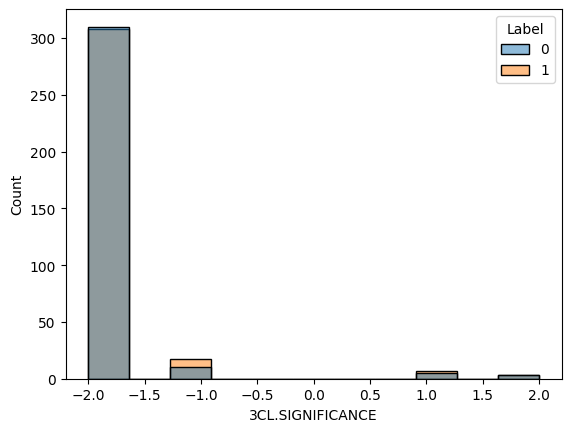

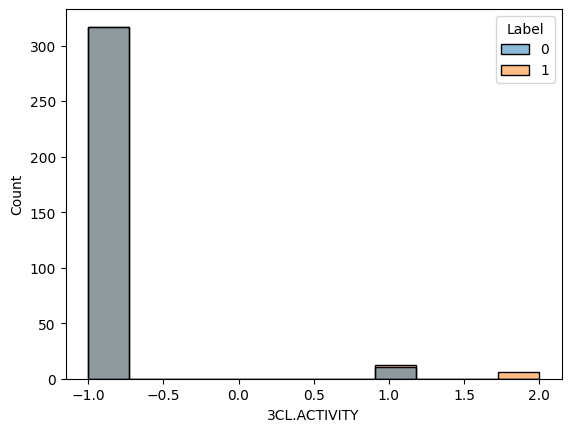

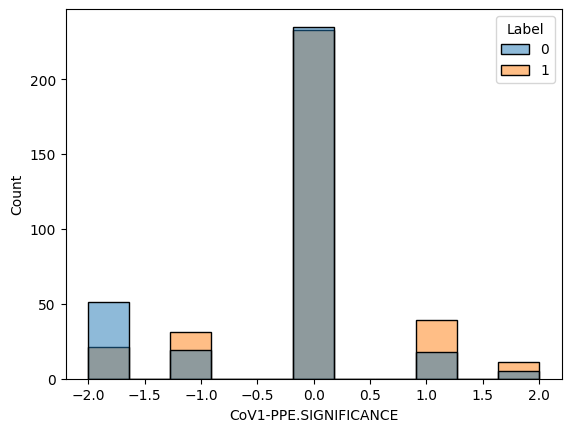

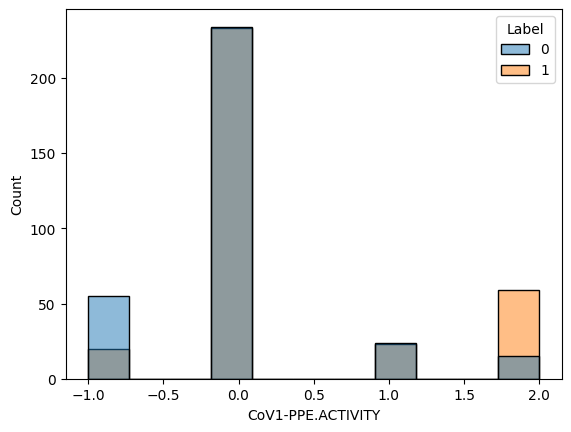

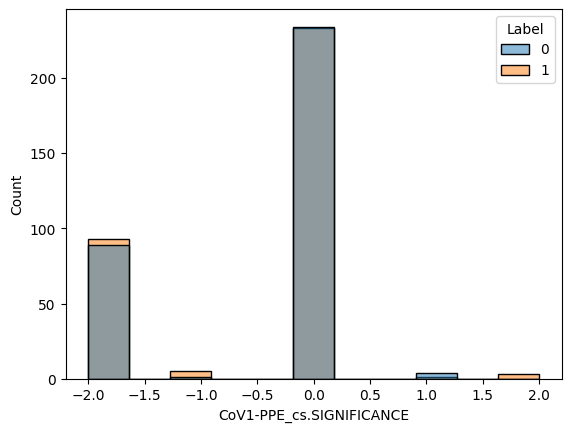

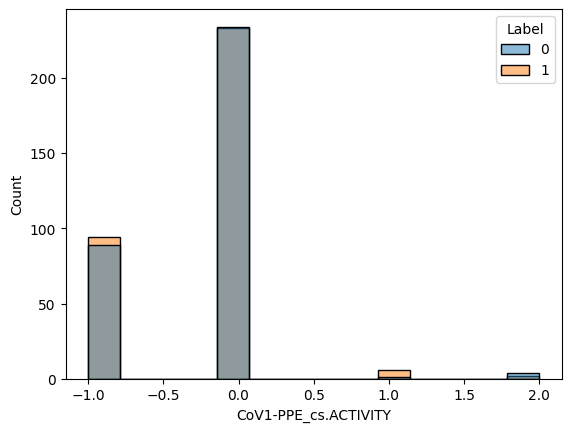

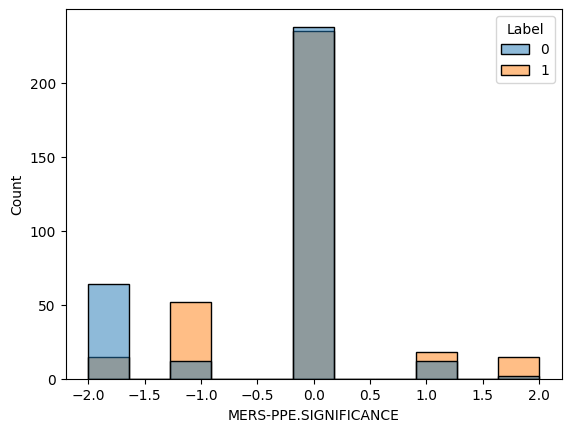

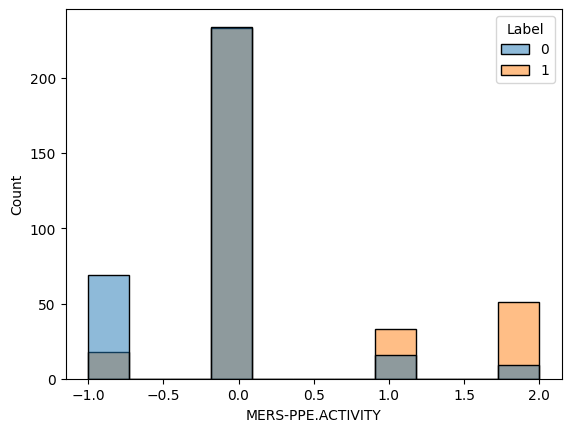

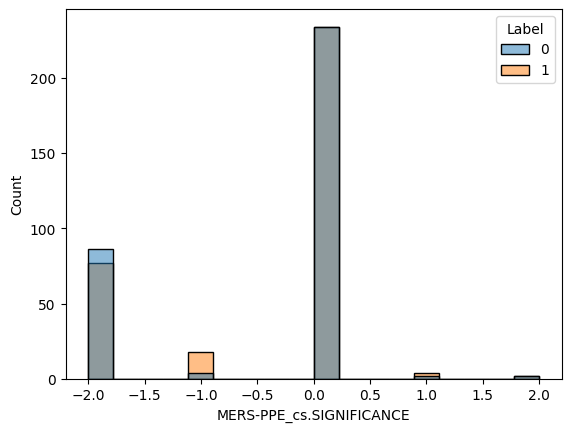

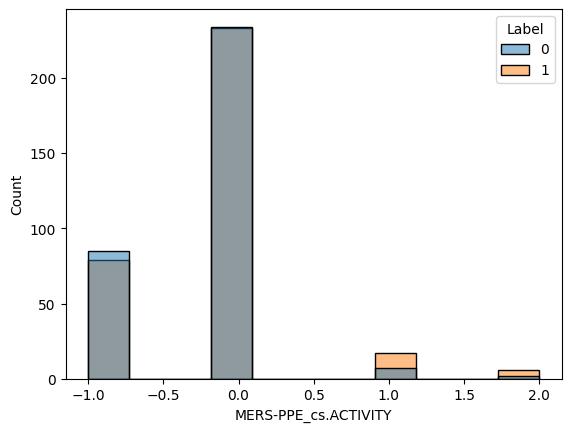

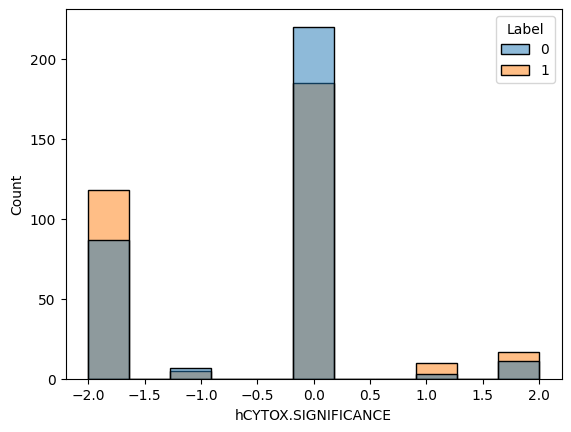

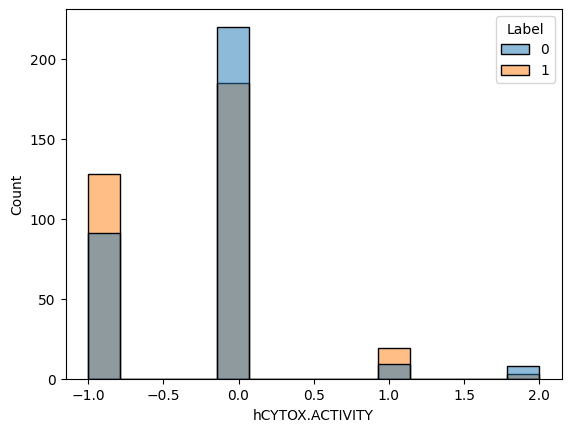

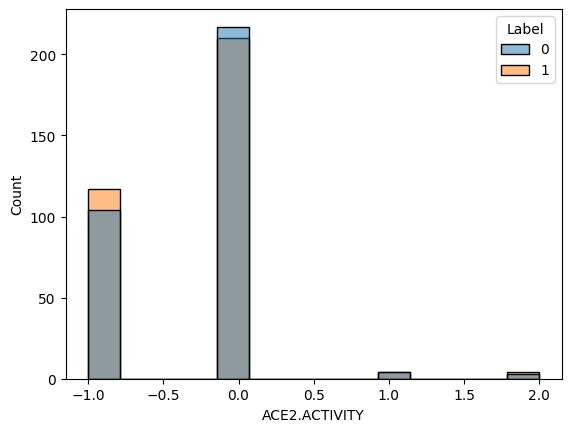

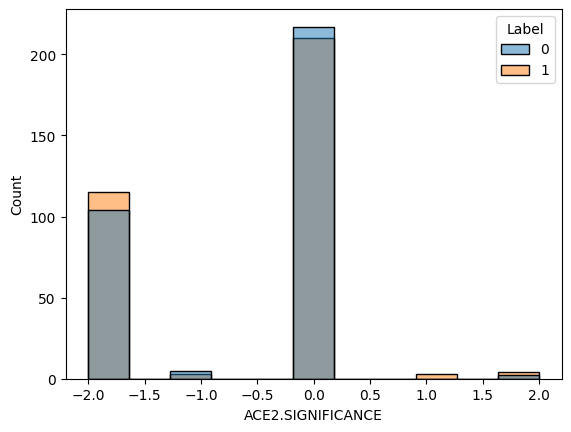

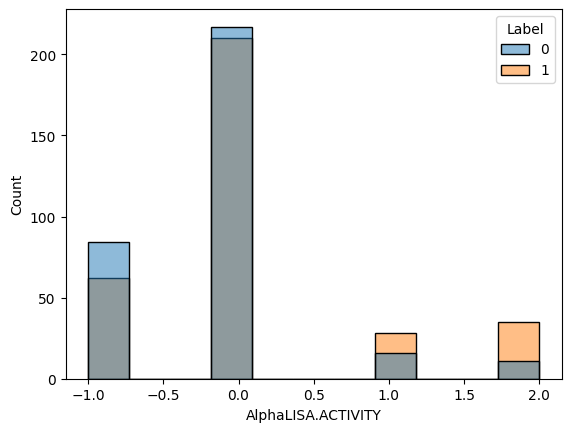

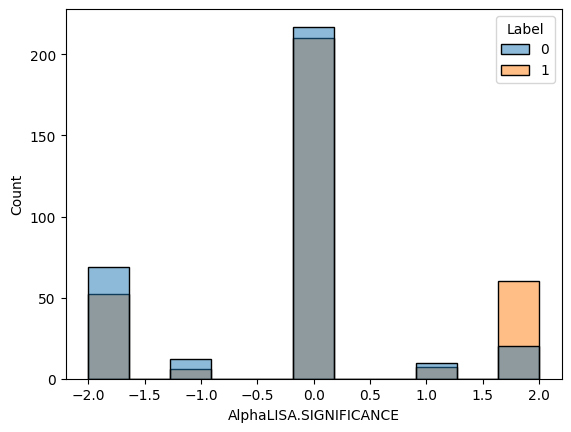

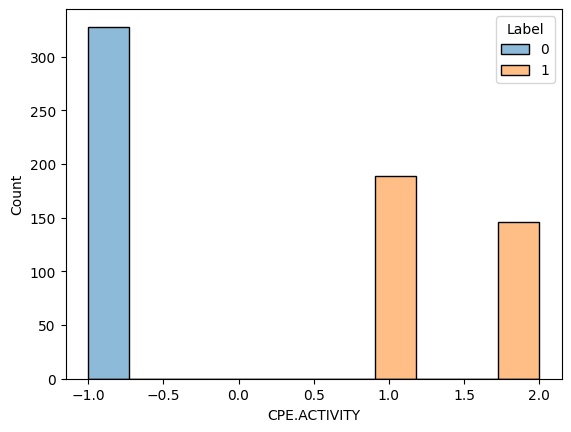

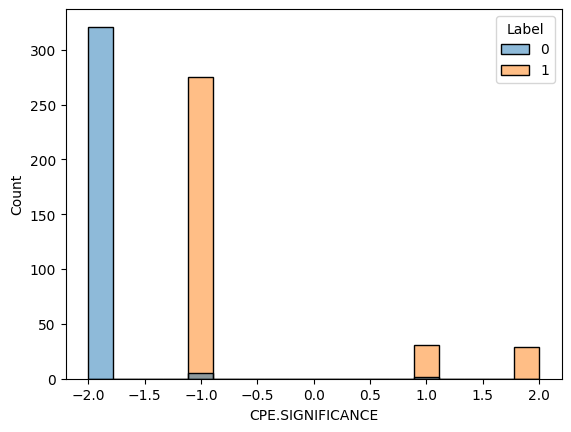

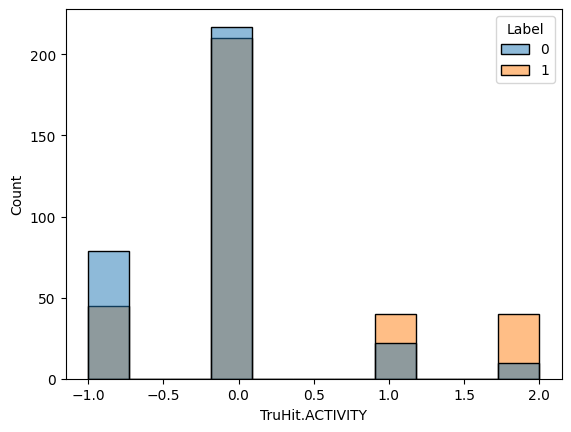

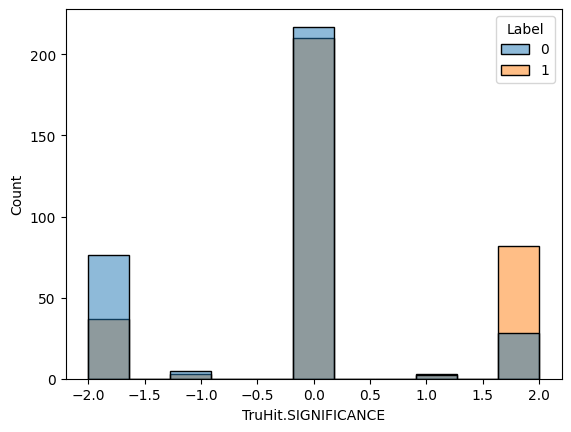

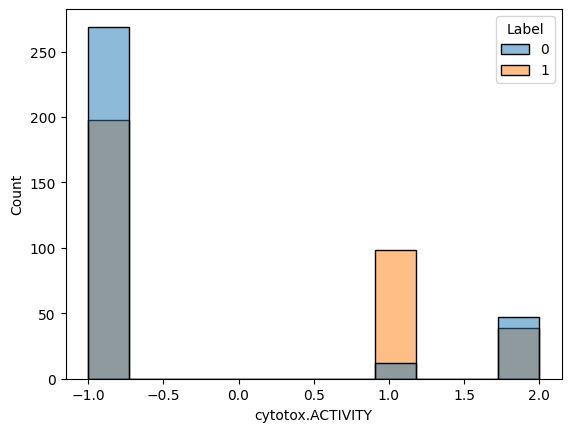

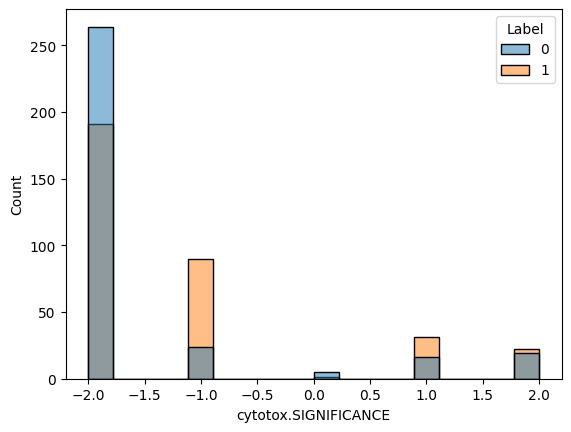

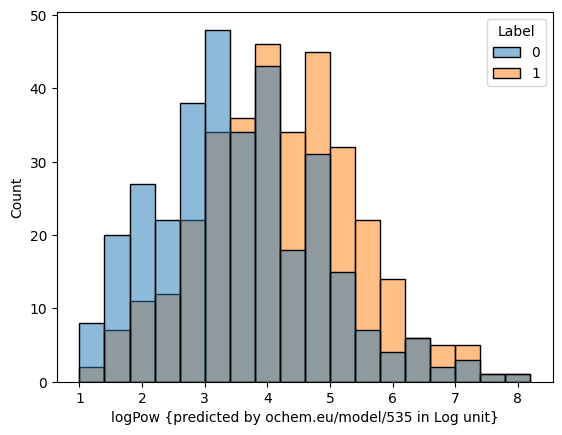

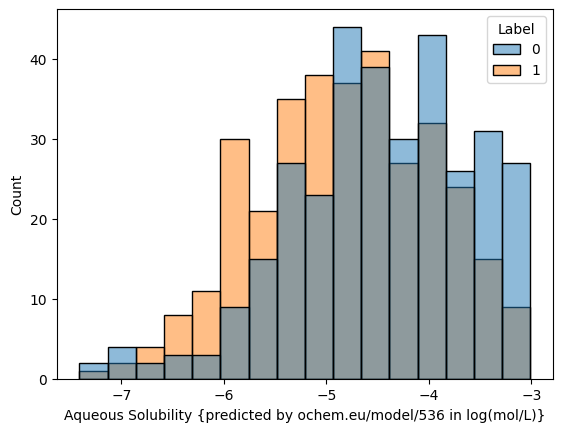

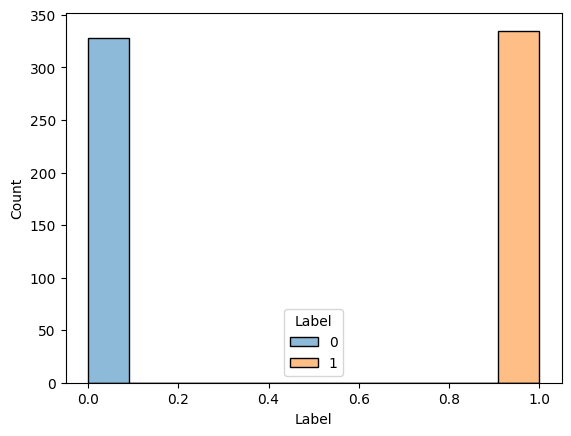

In [21]:
for column in train.columns:
    if train[column].dtype!='O':
        sns.histplot(data=train, x=column, hue='Label')
        plt.show()

In [22]:
train=train.reset_index(drop=True)

Some additional features can be extracted based on SMILES values 

In [23]:
features = []
for smiles in tqdm(train.SMILES):
    mol = Chem.MolFromSmiles(smiles)
    feature_dict = {
        'MolWt': Descriptors.MolWt(mol),
        #'MolLogP': Descriptors.MolLogP(mol),
        'TPSA': Descriptors.TPSA(mol),
        'NumRotatableBonds': Descriptors.NumRotatableBonds(mol),
        'NumHAcceptors': Descriptors.NumHAcceptors(mol),
        'NumHDonors': Descriptors.NumHDonors(mol)
    }
    features.append(feature_dict)
features_df = pd.DataFrame(features)
train = pd.concat([train, features_df], axis=1)

100%|██████████| 663/663 [00:00<00:00, 1933.10it/s]


'MOL.ID', 'SMILES_stand', 'InChI', 'SMILES' provide no information for model

In [24]:
train=train.drop(['MOL.ID', 'SMILES_stand', 'InChI', 'SMILES'], axis=1)
train.head()

,3CL.SIGNIFICANCE,3CL.ACTIVITY,CoV1-PPE.SIGNIFICANCE,CoV1-PPE.ACTIVITY,CoV1-PPE_cs.SIGNIFICANCE,CoV1-PPE_cs.ACTIVITY,MERS-PPE.SIGNIFICANCE,MERS-PPE.ACTIVITY,MERS-PPE_cs.SIGNIFICANCE,MERS-PPE_cs.ACTIVITY,...,cytotox.ACTIVITY,cytotox.SIGNIFICANCE,logPow {predicted by ochem.eu/model/535 in Log unit},Aqueous Solubility {predicted by ochem.eu/model/536 in log(mol/L)},Label,MolWt,TPSA,NumRotatableBonds,NumHAcceptors,NumHDonors
0,-2,-1,0,0,0,0,0,0,0,0,...,-1,-2,2.72,-5.34,0,385.485,72.47,9,5,1
1,-2,-1,0,0,0,0,0,0,0,0,...,-1,-2,6.12,-7.14,1,454.566,63.60,6,3,1
2,-2,-1,0,0,0,0,0,0,0,0,...,-1,-2,2.96,-4.49,0,406.417,86.11,3,6,1
3,-2,-1,-2,-1,-2,-1,-2,-1,-2,-1,...,1,2,1.26,-3.96,0,729.908,146.39,4,12,2
4,-2,-1,0,0,0,0,0,0,0,0,...,1,2,4.80,-3.84,1,524.625,102.33,6,9,1


Preparing training data

In [25]:
X_train=train.drop(['Label'], axis=1)
y_train=train['Label']

Training the model

In [26]:
model = xgb.XGBClassifier()
model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              predictor=None, random_state=None, ...)

For validation data I am going to use my pipeline which basically does all of the operations that I have performed on training data before (check custom_pipeline.py)

In [27]:
drop_columns = ['WARNING', 'DC.ID', 'DC.NAME', 'NCATS.SYNONYMS', 'NCGC.ID', 'MOL.ID', 'SMILES_stand', 'InChI', 'SMILES']
impute_unknown_columns = sign_and_act_cols
replace_inconclusive_columns = sign_and_act_cols
impute_mean_columns = ['logPow {predicted by ochem.eu/model/535 in Log unit}', 'Aqueous Solubility {predicted by ochem.eu/model/536 in log(mol/L)}']


pipeline = [
    NaNImputer(columns=impute_unknown_columns, value='UNKNOWN'),
    MeanImputer(columns=impute_mean_columns),
    InconclusiveReplacer(columns=replace_inconclusive_columns, replacement='UNKNOWN'),
    MappingTransformer(mapping={
        'INACTIVE': -2,
        'LOW': -1,
        'UNKNOWN': 0,
        'MODERATE': 1,
        'HIGH': 2
    }),
    FeatureExtractor(),
    ColumnDropper(columns=drop_columns)
]

In [29]:
validation=pd.read_csv('data/validation-set.csv')
SMILES=validation['SMILES_stand'].tolist()
for transformer in pipeline:
    validation = transformer.fit_transform(validation)

100%|██████████| 150/150 [00:00<00:00, 1065.34it/s]


Evaluating the model

In [30]:
X_test=validation.drop(['Label'], axis=1)
y_test=validation['Label']
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

Accuracy: 1.0


Creating the submission.csv file for Kaggle

In [31]:
pd.DataFrame({'SMILES_stand' : SMILES, 'Label' : y_pred}).set_index('SMILES_stand').to_csv('data/sample-submission.csv')